# RNN with formatted text data

In [7]:
import pandas as pd
import os
import numpy as np
import wandb

In [8]:
wandb.init(project='Scratch_RNN', name='Scratch_RNN_reduced')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
df = pd.read_csv('../datasets/post_sub.csv')
df.head()

,post,subreddit
0,Lethargic/Depressed when off meds First I'll g...,adhd
1,Concerta not working on the first day?! Update...,adhd
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd
4,I absolutely hate being so motivated but equal...,adhd


<Axes: title={'center': 'Number posts in each Subreddit'}, xlabel='subreddit'>

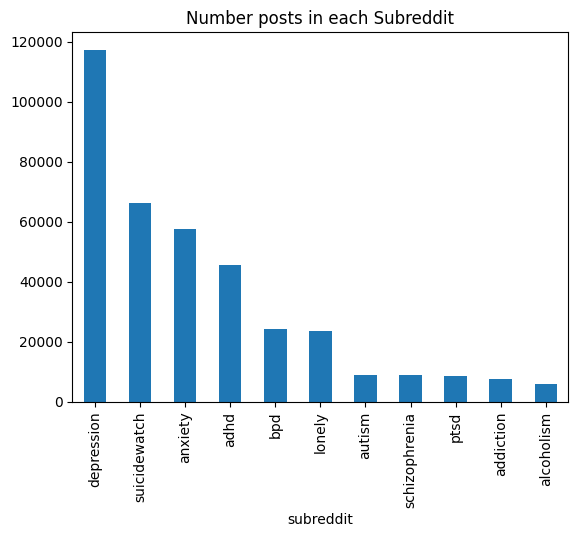

In [10]:
df['subreddit'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number posts in each Subreddit')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

## Cleaning post data and tokenizing it

In [12]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


True

Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CompletedProcess(args=['unzip', '/kaggle/working/corpora/wordnet.zip', '-d', '/kaggle/working/corpora'], returncode=1)

In [13]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer


# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text

    # Lemmatize the text
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)

    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [14]:
count = df['post'].apply(lambda x: len(x.split()))

In [16]:
# Get indexes of rows where subreddit is 'depression'
depression_rows = df[df['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.57)  # 45% of the rows to keep

# Randomly select 45% of the rows to keep
rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

# Remove 55% of rows with subreddit 'depression'
df.drop(rows_to_remove_indexes, inplace=True)

In [18]:
# Print count of each class
print(df['subreddit'].value_counts())

subreddit
depression       66878
suicidewatch     66161
anxiety          57671
adhd             45631
bpd              24294
lonely           23635
autism            8869
schizophrenia     8712
ptsd              8643
addiction         7641
alcoholism        5911
Name: count, dtype: int64


In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 285545 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (324046, 300)


In [21]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (324046, 11)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [26]:
# print tensorflow version
import tensorflow as tf
print(tf.__version__)

2.13.0


## Training and evaluating the model with WandB

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTMCell, RNN, Dense, GRUCell, GRU
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm

# Convert your data to PyTorch tensors
X_train_torch = torch.from_numpy(X_train).long()  
Y_train_torch = torch.from_numpy(Y_train).long()  

X_val_torch = torch.from_numpy(X_val).long() 
Y_val_torch = torch.from_numpy(Y_val).long()  

X_test_torch = torch.from_numpy(X_test).long()  
Y_test_torch = torch.from_numpy(Y_test).long() 


# Model Parameters
input_size = X_train.shape[1]
# hidden_size = 64
num_classes = len(np.unique(Y))
hidden_units = 300  


# Define the model with LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTMCell(embedding_dim, hidden_units)
        self.dense = nn.Linear(hidden_units, 11)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = self.dropout(embeds)
        
        h_t = torch.zeros(x.size(0), hidden_units, dtype=torch.float).cuda()
        c_t = torch.zeros(x.size(0), hidden_units, dtype=torch.float).cuda()
        
        for t in range(x.size(1)):
            h_t, c_t = self.lstm(embeds[:, t, :], (h_t, c_t))
        
        output = self.dense(h_t)
        output = self.softmax(output)
        return output


# Initialize the model, criterion, and optimizer
model = LSTMModel(MAX_NB_WORDS, EMBEDDING_DIM, hidden_units).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 7
batch_size = 16

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for idx in range(0, len(X_train_torch), batch_size):
        optimizer.zero_grad()
        batch_x = X_train_torch[idx:idx+batch_size].cuda()
        batch_y = Y_train_torch[idx:idx+batch_size].cuda()
        
        output = model(batch_x)
        loss = criterion(output, torch.argmax(batch_y, axis=1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print('EPOCH done')
    # Validation
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        accuracy = 0.0
        for idx in range(0, len(X_val_torch), batch_size):
            batch_x = X_val_torch[idx:idx+batch_size].cuda()
            batch_y = Y_val_torch[idx:idx+batch_size].cuda()
            val_output = model(batch_x)
            val_loss += criterion(val_output, torch.argmax(batch_y, axis=1)).item()
            _,predicted = torch.max(val_output, 1)
            accuracy += (predicted == torch.argmax(batch_y, axis=1)).sum().item() / len(batch_y)
        accuracy = accuracy/ (len(X_test_torch)/batch_size)
        val_loss = val_loss / (len(X_val_torch)/batch_size)
        print(f'Validation Loss: {val_loss}', f'Validation Accuracy: {accuracy}')
        wandb.log({'val_loss': val_loss, 'val_acc': accuracy})



LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 1.3213653177886069 Validation Accuracy: 0.549844845617103


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.9953647288335237 Validation Accuracy: 0.6633647070925268


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.8417340937879034 Validation Accuracy: 0.7136004388897461


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.7925596079381001 Validation Accuracy: 0.7302062438924034


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.7736703987433102 Validation Accuracy: 0.7356032162389207


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.7672622373308673 Validation Accuracy: 0.7380565413430712


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

EPOCH done


LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Validation Loss: 0.7523239528441783 Validation Accuracy: 0.7422379948224725


In [29]:
# Testing
with torch.no_grad():
    model.eval()
    test_loss = 0.0
    accuracy = 0.0
    for idx in range(0, len(X_test_torch), batch_size):
        batch_x = X_test_torch[idx:idx+batch_size].cuda()
        batch_y = Y_test_torch[idx:idx+batch_size].cuda()
        test_output = model(batch_x)
        test_loss += criterion(test_output, torch.argmax(batch_y, axis=1)).item()
        _, predicted = torch.max(test_output, 1)
        accuracy += (predicted == torch.argmax(batch_y, axis=1)).sum().item() / len(batch_y)
    accuracy = accuracy/ (len(X_test_torch)/batch_size)
    test_loss = test_loss / (len(X_test_torch)/batch_size)
    print(f'Test set\n  Loss: {test_loss}\n  Accuracy: {accuracy}')
    wandb.log({'test_loss': test_loss, 'test_acc' : accuracy })
    

LSTMModel(
  (embedding): Embedding(50000, 200)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTMCell(200, 300)
  (dense): Linear(in_features=300, out_features=11, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Test set
  Loss: 0.7525470029275886
  Accuracy: 0.7434161394846475


In [30]:
# Save the model's state dictionary
torch.save(model.state_dict(), './model_state.pth')
wandb.finish()

test_acc,▁
test_loss,▁
val_acc,▁▅▇████
val_loss,█▄▂▁▁▁▁
test_acc,0.74342
test_loss,0.75255
val_acc,0.74224
val_loss,0.75232
